In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from time import perf_counter as timer
import warnings

from src import *

In [2]:
def Get_modified_commitments_matrix(
    generators: Generators, others: Others, committed_generators: Committed_generators,
    idx_nan_model1):
    
    modified_commitments_matrix = others.commitments_matrix.copy() # to be updated
    marginal_unit_idx_and_hour = {} # marginal unit; cus demand not necessarily exactly equals the modified pmin sum this unit is responsible for producing the deficit (which is below its original pmin)

    for idx_hour in idx_nan_model1:
        committed_generators.Get_committed_generators(idx_hour) # unmodified committed generators class 
        demand = others.thermalgen_demands[idx_hour] # for comparison
        modified_commitments = committed_generators.commitments.copy()

        while True:
            current_commitments = modified_commitments
            current_idx_committed = np.where(current_commitments == 1)[0]   

            # updating necesssary vars
            committed_gen_pmin = generators.gen_pmin[current_idx_committed] 
            committed_gencost_c2 = generators.gencost_c2[current_idx_committed]
            committed_gencost_c1 = generators.gencost_c1[current_idx_committed]
            
            total_pmin = committed_gen_pmin.sum()
            if total_pmin <= demand: # discretely turning off one by one give me feasible -> break
                break

            mc_gen_pmin = 2 * committed_gencost_c2 * committed_gen_pmin + committed_gencost_c1
            idx_highest_mc = np.argmax(mc_gen_pmin)
            idx_gen_turn_off = current_idx_committed[idx_highest_mc]
            modified_commitments[idx_gen_turn_off] = 0

        # for overshoot correction
        surplus = demand - total_pmin
        if surplus > 0:
            modified_commitments[idx_gen_turn_off] = 1
            marginal_unit_idx_and_hour[idx_hour] = idx_gen_turn_off

        modified_commitments_matrix[idx_hour] = modified_commitments

    return modified_commitments_matrix, marginal_unit_idx_and_hour

In [3]:
# instantiation
basics = Basics()
generators = Generators(basics)
others = Others(basics)
committed_generators = Committed_generators(generators, others)
solver = Solver(generators, others, committed_generators)

# modify commitments_matrix    
idx_nan_model1 = np.where(np.load(f"{os.getcwd()}/data/outputs/main_1/result_status.npy") == -1)[0] 
others.commitments_matrix, marginal_unit_idx_and_hour = Get_modified_commitments_matrix(generators, others, committed_generators, idx_nan_model1)
# np.save(f"{os.path.abspath(__file__).split("main_2.py")[0]}/data/inputs/modified_commitments_matrix.npy", others.commitments_matrix)
real_smp = np.load(f"{os.getcwd()}/data/inputs/real_smp_2022.npy")

# re-instantiation
committed_generators = Committed_generators(generators, others)
solver = Solver(generators, others, committed_generators)

In [4]:
# computing SMP for every hour in 2022 based on KPG dataset 
result_status, result_smp, result_p_error_demand, result_cost_system, result_powers_by_source, result_cost_by_source = [], [], [], [], [], []

for idx_hour in range(0, 8760):
    committed_generators.Get_committed_generators(idx_hour)

    if idx_hour in marginal_unit_idx_and_hour:
        committed_generators.Get_committed_generators(idx_hour)
        idx_marginal_unit_gen = marginal_unit_idx_and_hour[idx_hour]
        committed_generators.committed_gen_pmin[
            np.where(committed_generators.commitments == 1)[0].tolist().index(idx_marginal_unit_gen)
            ] = 0

    solver.Compute_smp(idx_hour=idx_hour, save_powers_by_bus=False)

    result_status.append(solver.status)
    result_smp.append(solver.smp)
    result_p_error_demand.append(solver.p_error_demand)
    result_cost_system.append(solver.cost_system)
    result_powers_by_source.append(solver.powers_by_source) 
    result_cost_by_source.append(solver.cost_by_source)

In [5]:
# result organization, summary print, result saving
result_status, result_smp, result_p_error_demand, result_cost_system, result_powers_by_source, result_cost_by_source = np.array(result_status), np.array(result_smp), np.array(result_p_error_demand), np.array(result_cost_system), np.array(result_powers_by_source), np.array(result_cost_by_source) # i do this because list appending is faster than nparray but i need nparray afterall
result_cost_system *= 1000
result_cost_by_source *= 1000
idx_nonan = np.where(result_status == 0)[0]

---
---
---

In [6]:
# for monthly plots
idxs_hour_month_start = np.array([0, 744, 1416, 2160, 2880, 3624, 4344, 5088, 5832, 6552, 7296, 8016])
idxs_hour_month_end = np.concatenate((np.delete(idxs_hour_month_start, 0), np.array([8760]))) - 1
iterators_month = [range(start, (end + 1)) for start, end in zip(idxs_hour_month_start, idxs_hour_month_end)]
month_names = {
    0: "January", 1: "February", 2: "March", 3: "April",
    4: "May", 5: "June", 6: "July", 7: "August",
    8: "September", 9: "October", 10: "November", 11: "December"
}

idx_hour_spc_start, idx_hour_spc_end = 0, 8759
# idx_hour_spc_start, idx_hour_spc_end = idxs_hour_month_start[3], idxs_hour_month_start[3] + 24
# idx_hour_spc_start, idx_hour_spc_end = idxs_hour_month_start[6] + 24 * 1, idxs_hour_month_start[6] + 24 * 2
# idx_hour_spc_start, idx_hour_spc_end = idxs_hour_month_start[10] + 24 * 1, idxs_hour_month_start[10] + 24 * 2

iterator = range(idx_hour_spc_start, (idx_hour_spc_end + 1))

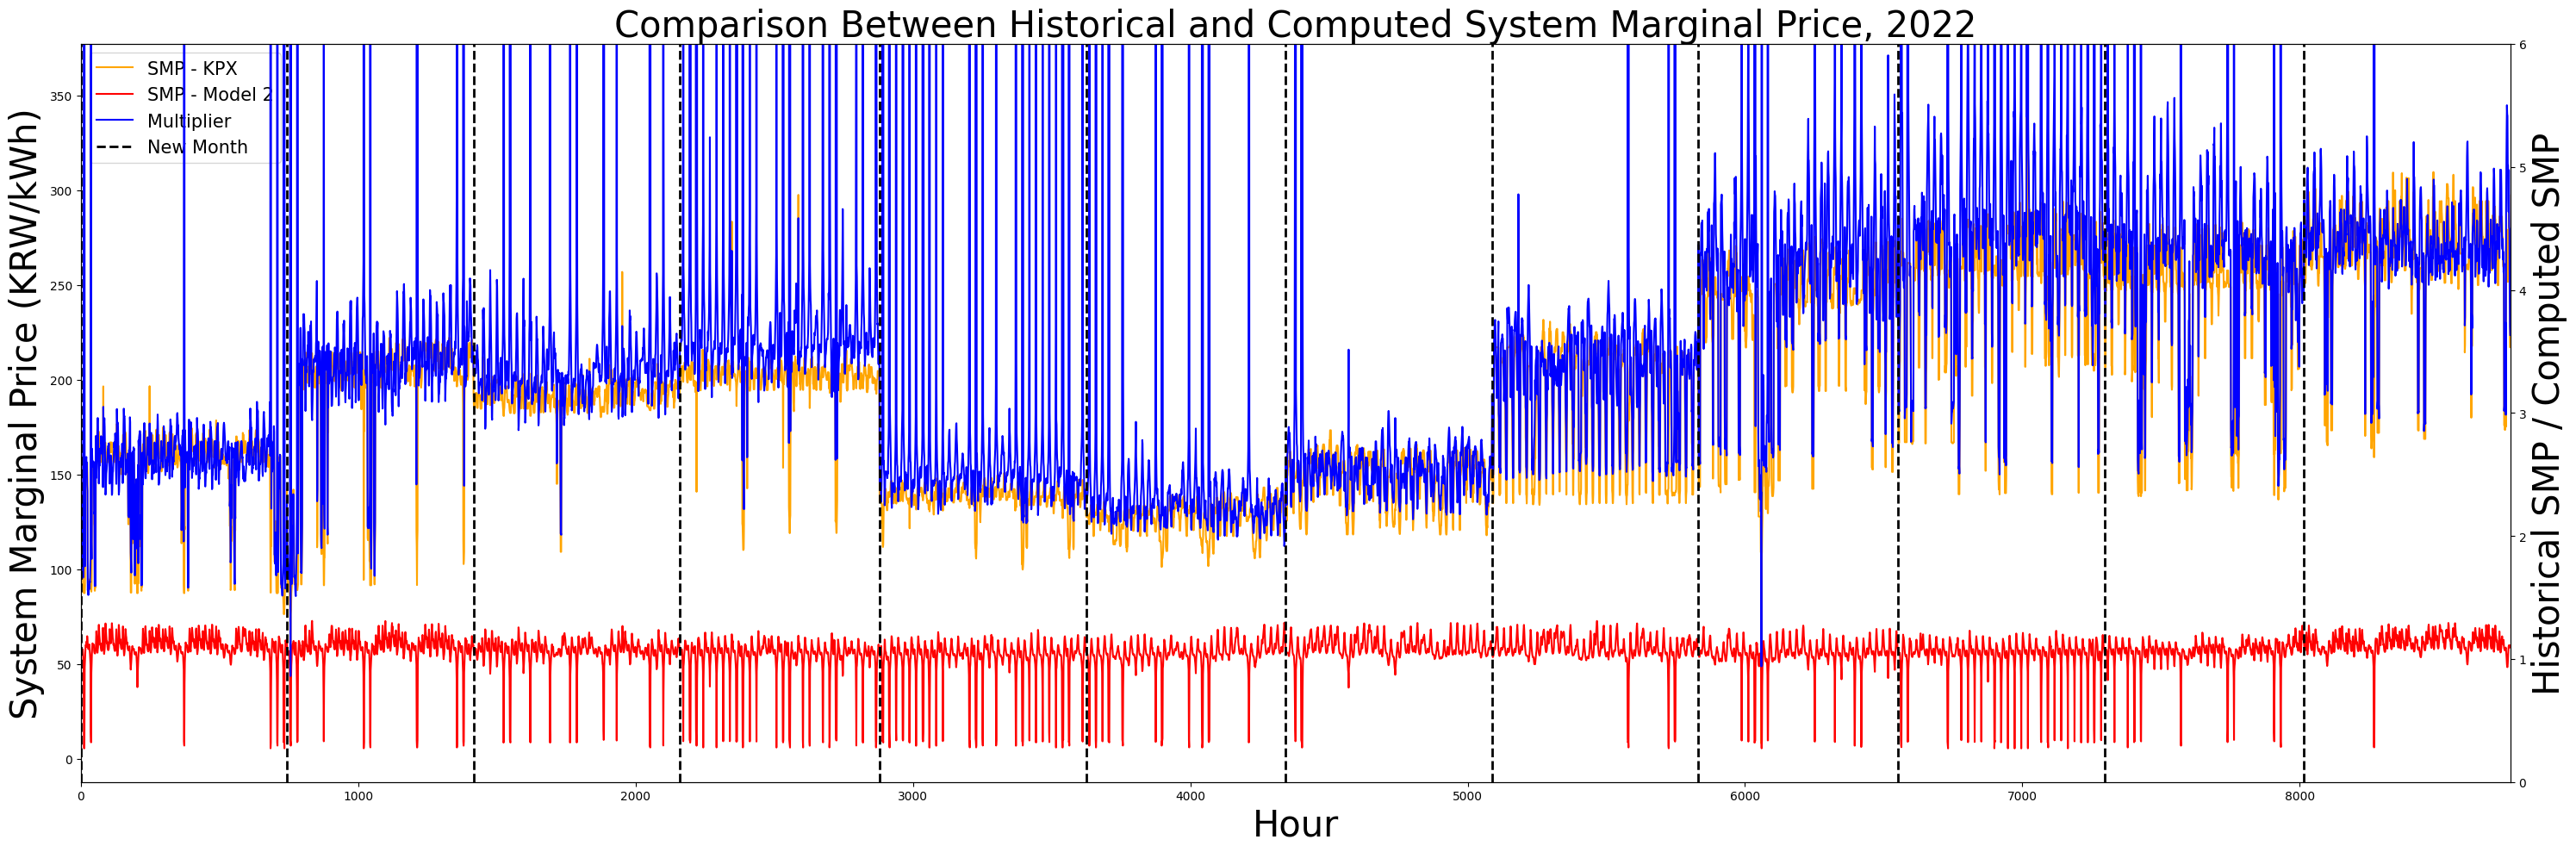

In [7]:
multiplier = real_smp / result_smp

fig, ax1 = plt.subplots(1, 1, figsize=(30, 10))
ax2 = ax1.twinx()

l1, = ax1.plot(iterator, real_smp[idx_hour_spc_start:idx_hour_spc_end+1], color="orange", label="SMP - KPX")
l2, = ax1.plot(iterator, result_smp[idx_hour_spc_start:idx_hour_spc_end+1], color="red", label="SMP - Model 2")
l3, = ax2.plot(iterator, multiplier[idx_hour_spc_start: idx_hour_spc_end+1], color="blue", label="Multiplier")
l4 = ax2.vlines(x=idxs_hour_month_start, ymin=0, ymax=6, colors="black", linewidth=2, linestyles="--", label="New Month")

ax1.set_title("Comparison Between Historical and Computed System Marginal Price, 2022", fontsize=30)
ax1.set_xlabel("Hour", fontsize=30)
ax1.set_ylabel("System Marginal Price (KRW/kWh)", fontsize=30)
ax2.set_ylabel("Historical SMP / Computed SMP", fontsize=30)


ax1.set_xlim((idx_hour_spc_start - 0.5, idx_hour_spc_end + .5))
ax2.set_ylim((0, 6))
lines = [l1, l2, l3, l4]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc="upper left", fontsize=15)

plt.tight_layout()
plt.show(fig)

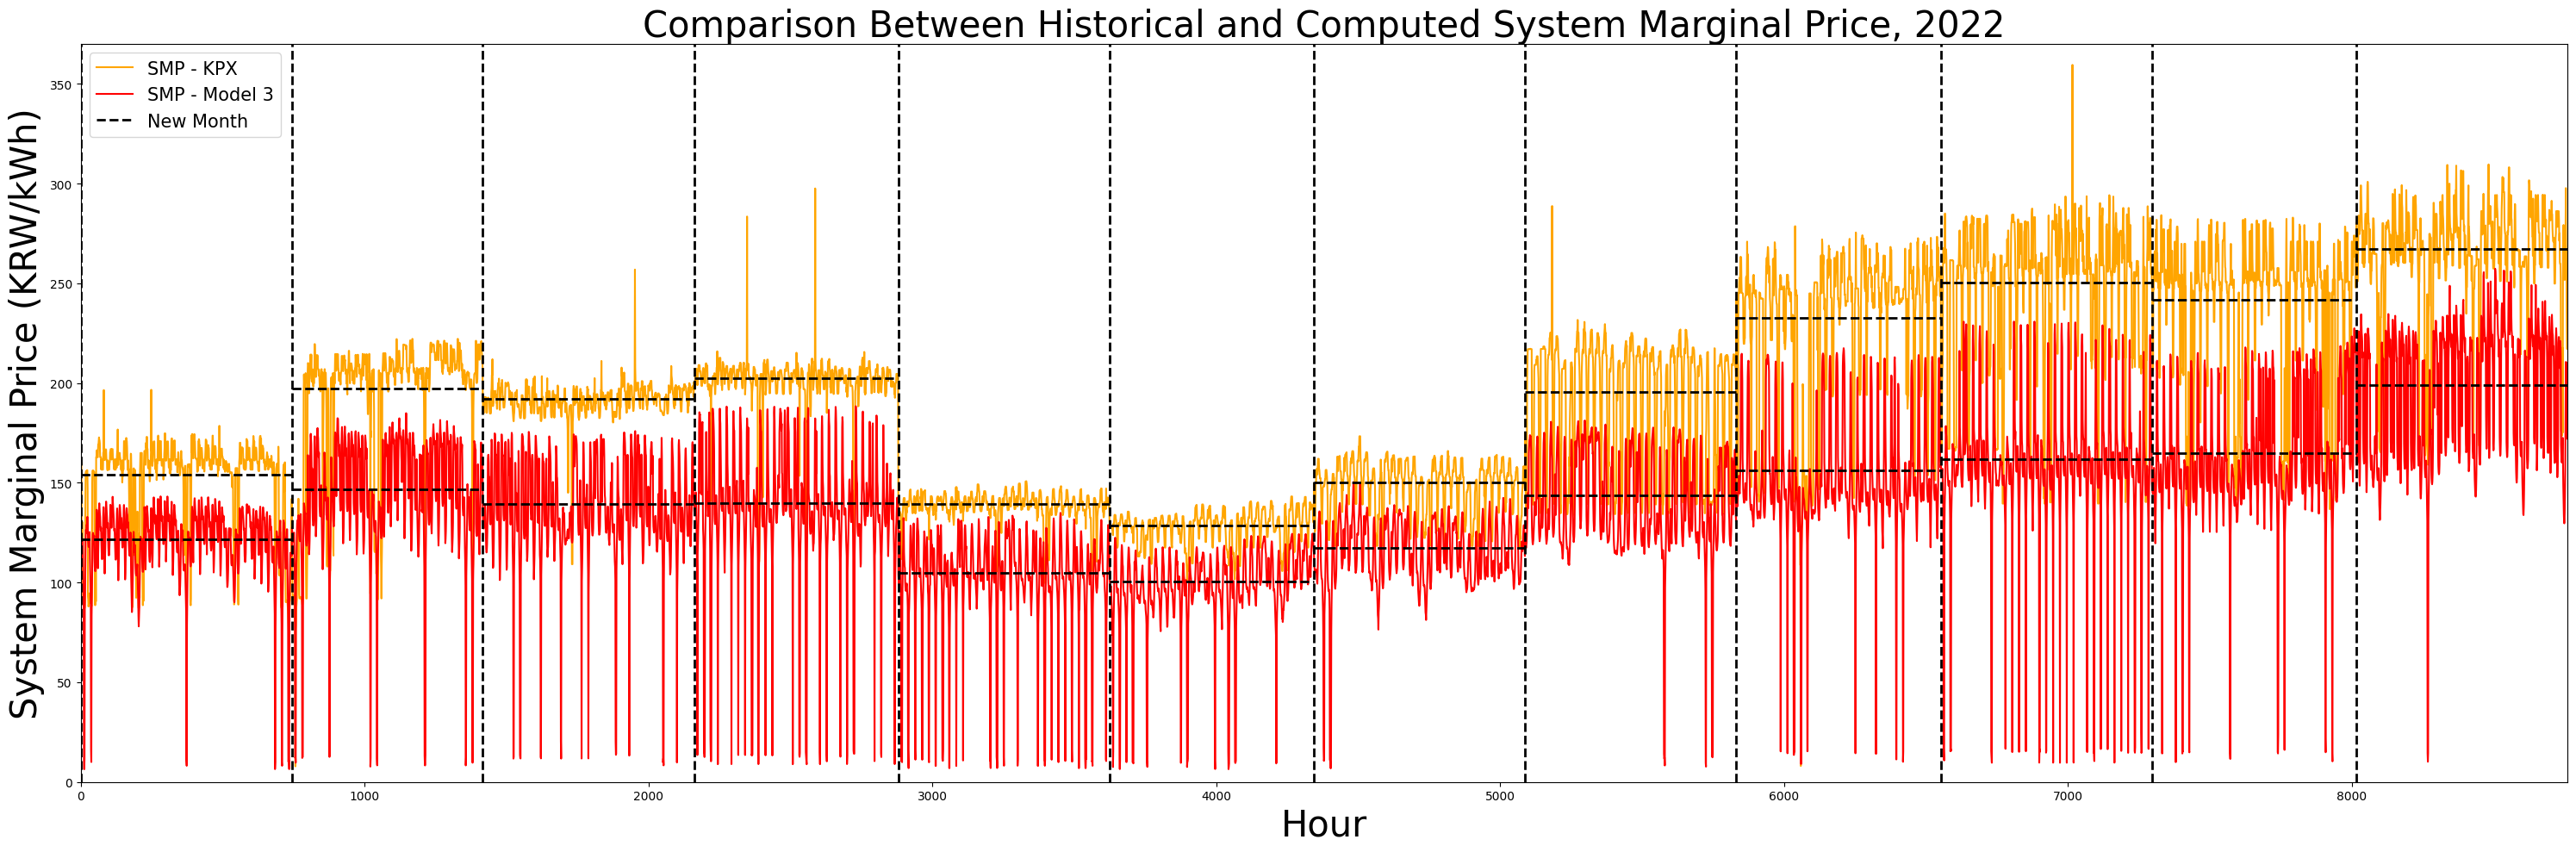

In [15]:
fig, ax1 = plt.subplots(1, 1, figsize=(30, 10))
# ax2 = ax1.twinx()

l1, = ax1.plot(iterator, real_smp[idx_hour_spc_start:idx_hour_spc_end+1], color="orange", label="SMP - KPX")
l2, = ax1.plot(iterator, result_smp[idx_hour_spc_start:idx_hour_spc_end+1], color="red", label="SMP - Model 3")
# l3, = ax2.plot(iterator, multiplier[idx_hour_spc_start: idx_hour_spc_end+1], color="blue", label="Multiplier")
l4 = ax1.vlines(x=idxs_hour_month_start, ymin=0, ymax=370, colors="black", linewidth=2, linestyles="--", label="New Month")

# plot monthly weighted average lines for SMP
for month in range(12):
    idx_start = idxs_hour_month_start[month]
    idx_end = idxs_hour_month_end[month]
    result_smp_weighted_avg = (result_smp[idx_start:idx_end+1] * others.thermalgen_demands[idx_start:idx_end+1]).sum() / others.thermalgen_demands[idx_start:idx_end+1].sum()
    ax1.hlines(result_smp_weighted_avg, xmin=idx_start, xmax=idx_end, colors="black", linestyles="--", linewidth=2)
    real_smp_weighted_avg = (real_smp[idx_start:idx_end+1] * others.thermalgen_demands[idx_start:idx_end+1]).sum() / others.thermalgen_demands[idx_start:idx_end+1].sum()
    ax1.hlines(real_smp_weighted_avg, xmin=idx_start, xmax=idx_end, colors="black", linestyles="--", linewidth=2)

ax1.set_title("Comparison Between Historical and Computed System Marginal Price, 2022", fontsize=30)
ax1.set_xlabel("Hour", fontsize=30)
ax1.set_ylabel("System Marginal Price (KRW/kWh)", fontsize=30)
# ax2.set_ylabel("Historical SMP / Computed SMP", fontsize=30)

ax1.set_ylim((0, 370))
ax1.set_xlim((idx_hour_spc_start - 0.5, idx_hour_spc_end + .5))
# ax2.set_ylim((0, 6))
# lines = [l1, l2, l3, l4]
# labels = [line.get_label() for line in lines]
ax1.legend(loc="upper left", fontsize=15)

plt.tight_layout()
plt.show(fig)


In [9]:
def calculate_monthly_weighted_avg(smp_array, thermal_demands, idxs_hour_month_start, idxs_hour_month_end):
    smp_monthly_weighted_avg = []
    for month in range(12):
        idx_start = idxs_hour_month_start[month]
        idx_end = idxs_hour_month_end[month]
        weighted_avg = (smp_array[idx_start:idx_end+1] * thermal_demands[idx_start:idx_end+1]).sum() / thermal_demands[idx_start:idx_end+1].sum()
        smp_monthly_weighted_avg.append(weighted_avg)
    return np.array(smp_monthly_weighted_avg)

result_smp_monthly_weighted_avg = calculate_monthly_weighted_avg(result_smp, others.thermalgen_demands, idxs_hour_month_start, idxs_hour_month_end)
real_smp_monthly_weighted_avg = calculate_monthly_weighted_avg(real_smp, others.thermalgen_demands, idxs_hour_month_start, idxs_hour_month_end)

In [10]:
smp_multipliers_monthly = real_smp_monthly_weighted_avg / result_smp_monthly_weighted_avg

In [11]:
smp_multipliers_monthly

array([2.57794789, 3.33462301, 3.35463098, 3.68559961, 2.57979724,
       2.30434847, 2.53329207, 3.31349166, 4.13014793, 4.53239056,
       4.24779204, 4.35245879])

In [ ]:
modified_set_gencost_c1 = []

for month in range(12):
    c1 = generators.gencost_c1.copy()
    multiplier = smp_multipliers_monthly[month]
    
    c1[generators.idx_gen_lng] *= multiplier
    c1[generators.idx_gen_coal] *= multiplier

    modified_set_gencost_c1.append(c1)

modified_set_gencost_c1 = np.array(modified_set_gencost_c1)

---
---
---

In [13]:
# computing SMP for every hour in 2022 based on KPG dataset 
result_status, result_smp, result_p_error_demand, result_cost_system, result_powers_by_source, result_cost_by_source = [], [], [], [], [], []

for idx_hour in range(0, 8760):
    for month in range(12):
        if idxs_hour_month_start[month] <= idx_hour <= idxs_hour_month_end[month]:
            generators.gencost_c1 = modified_set_gencost_c1[month].copy()
            break

    committed_generators.Get_committed_generators(idx_hour)

    if idx_hour in marginal_unit_idx_and_hour:
        committed_generators.Get_committed_generators(idx_hour)
        idx_marginal_unit_gen = marginal_unit_idx_and_hour[idx_hour]
        committed_generators.committed_gen_pmin[
            np.where(committed_generators.commitments == 1)[0].tolist().index(idx_marginal_unit_gen)
            ] = 0

    solver.Compute_smp(idx_hour=idx_hour, save_powers_by_bus=False)

    result_status.append(solver.status)
    result_smp.append(solver.smp)
    result_p_error_demand.append(solver.p_error_demand)
    result_cost_system.append(solver.cost_system)
    result_powers_by_source.append(solver.powers_by_source) 
    result_cost_by_source.append(solver.cost_by_source)

In [14]:
# result organization, summary print, result saving
result_status, result_smp, result_p_error_demand, result_cost_system, result_powers_by_source, result_cost_by_source = np.array(result_status), np.array(result_smp), np.array(result_p_error_demand), np.array(result_cost_system), np.array(result_powers_by_source), np.array(result_cost_by_source) # i do this because list appending is faster than nparray but i need nparray afterall
result_cost_system *= 1000
result_cost_by_source *= 1000
idx_nonan = np.where(result_status == 0)[0]

In [16]:
folder_path = f"{os.getcwd()}/data/outputs/main_3/"
os.makedirs(folder_path, exist_ok=True)
np.save(folder_path + "result_status.npy", result_status)
np.save(folder_path + "result_smp.npy", result_smp)
np.save(folder_path + "result_p_error_demand.npy", result_p_error_demand)
np.save(folder_path + "result_cost_system.npy", result_cost_system)
np.save(folder_path + "result_powers_by_source.npy", result_powers_by_source)
np.save(folder_path + "result_cost_by_source.npy", result_cost_by_source)
np.save(folder_path + "idx_nonan.npy", idx_nonan)